In [28]:
pip install wikipedia


[notice] A new release of pip available: 22.2 -> 25.0.1
[notice] To update, run: python3.8 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install geopy


[notice] A new release of pip available: 22.2 -> 25.0.1
[notice] To update, run: python3.8 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install pycountry


[notice] A new release of pip available: 22.2 -> 25.0.1
[notice] To update, run: python3.8 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install fuzzywuzzy


[notice] A new release of pip available: 22.2 -> 25.0.1
[notice] To update, run: python3.8 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import wikipedia
import pandas as pd
import numpy as np
import requests
import time
import pycountry
from fuzzywuzzy import process
from sklearn.linear_model import LinearRegression

In [5]:
def retrieve_database(url):
    table = pd.read_html(url)
    df = table[0]
    return df

data = retrieve_database('https://en.wikipedia.org/wiki/List_of_most-visited_museums#Most-visited_museums_in_2024')

In [6]:
def clean_number(val):
    if isinstance(val, str):
        v = val[:9]
        v = v.replace(',', '')
        v = v.lower().strip()
 
        if v.endswith(("mil", "milli", "mill")):
            num = ''.join(c for c in v if c.isdigit() or c == '.')
            return float(num) * 1_000_000

        try:
            return float(v)
        except ValueError:
            return None
    return val

data['Visitors in 2024'] = data['Visitors in 2024'].apply(clean_number)

In [7]:
def clean_city_name(city):
    return city.split(",")[0].strip()

data['City'] = data['City'].apply(clean_city_name)

In [57]:
def country_to_iso2(name):
    
    custom_map = {
    "Turkey": "TR",
    "Vatican": "VA",
    "Russia": "RU",
    "Iran": "IR",
    "South Korea": "KR",
    "North Korea": "KP"}

    country_names = [c.name for c in pycountry.countries]
    
    if pd.isna(name) or not name.strip():
        return None
    name = name.strip()

    if name in custom_map:
        return custom_map[name]
    
    try:
        return pycountry.countries.lookup(name).alpha_2
    except LookupError:
        pass
    
    for c in pycountry.countries:
        if hasattr(c, "official_name") and c.official_name.lower() == name.lower():
            return c.alpha_2

    match, score = process.extractOne(name, country_names)
    if score >= 80:
        try:
            return pycountry.countries.lookup(match).alpha_2
        except LookupError:
            return None
    
    return None

data["Country Code"] = data["Country"].apply(country_to_iso2)

In [32]:
USERNAME = "anna_v"

def get_population(city, country_code=None):
    base_url = "http://api.geonames.org/searchJSON"
    params = {
        "q": city,
        "maxRows": 10,
        "username": USERNAME
    }
    if country_code:
        params["country"] = country_code
    
    try:
        r = requests.get(base_url, params=params, timeout=5)
        r.raise_for_status()
        data = r.json()
        geonames = data.get("geonames", [])
        if geonames:
            best_match = max(geonames, key=lambda x: x.get("population", 0))
            pop = best_match.get("population")
            return int(pop) if pop else None
        else:
            return None
    except Exception as e:
        print(f"Error fetching {city}, {country_code}: {e}")
        return None

populations = []
for _, row in data.iterrows():
    pop = get_population(row["City"], row.get("Country Code"))
    populations.append(pop)
    time.sleep(1)

data["Population"] = populations

In [56]:
data

,Name,Visitors in 2024,City,Country,Country Code,Population
0,Louvre,8700000.0,Paris,France,FR,2138551
1,National Museum of China,6956800.0,Beijing,China,CN,18960744
2,Vatican Museums,6825436.0,Vatican City,Vatican,VA,921
3,British Museum,6479952.0,London,United Kingdom,GB,8961989
4,"Natural History Museum, South Kensington",6301972.0,London,United Kingdom,GB,8961989
...,...,...,...,...,...,...
80,Museum of European and Mediterranean Civilisat...,1300000.0,Marseille,France,FR,870731
81,Chinese Aviation Museum,1292278.0,Beijing,China,CN,18960744
82,Scottish National Gallery,1277230.0,Edinburgh,United Kingdom,GB,514990
83,Museo Reina Sofía,1253183.0,Madrid,Spain,ES,3255944


In [50]:
X = data[['Population']]

y = data['Visitors in 2024']

In [51]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [52]:
print(f"Coefficient (slope): {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")

Coefficient (slope): 0.010524502169073203
Intercept: 2694660.1414810745


In [53]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

Coefficient (slope): 0.010524502169073203
Intercept: 2694660.1414810745
R²: 0.0029179374389031176
RMSE: 1534980.7569868995


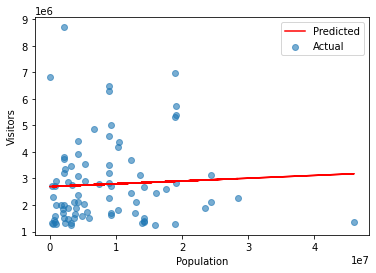

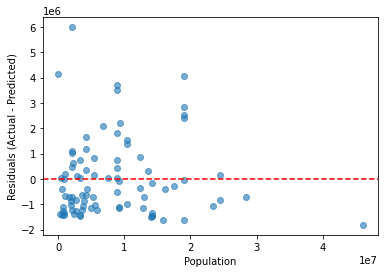

In [54]:
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = mse ** 0.5

print("Coefficient (slope):", model.coef_[0])
print("Intercept:", model.intercept_)
print("R²:", r2)
print("RMSE:", rmse)

plt.scatter(X, y, label="Actual", alpha=0.6)
plt.plot(X, y_pred, color="red", label="Predicted")
plt.xlabel("Population")
plt.ylabel("Visitors")
plt.legend()
plt.show()

plt.scatter(X, y - y_pred, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Population")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()

In [64]:
df = data.dropna(subset=["Visitors in 2024", "Population"]).copy()

X = df[["Population"]].values
y = df["Visitors in 2024"].values

lin_reg = LinearRegression()
lin_reg.fit(X, y)

print("Simple Linear Regression")
print(f"Coefficient (slope): {lin_reg.coef_[0]:.6f}")
print(f"Intercept: {lin_reg.intercept_:.2f}")
print(f"R² score: {lin_reg.score(X, y):.4f}")

Simple Linear Regression
Coefficient (slope): 0.010525
Intercept: 2694660.14
R² score: 0.0029



In [65]:
X_log = np.log1p(df["Population"].values.reshape(-1, 1))
y_log = np.log1p(df["Visitors in 2024"].values)

log_reg = LinearRegression()
log_reg.fit(X_log, y_log)

print("📊 Log-Log Regression")
print(f"Coefficient (slope): {log_reg.coef_[0]:.6f}")
print(f"Intercept: {log_reg.intercept_:.2f}")
print(f"R² score: {log_reg.score(X_log, y_log):.4f}")

📊 Log-Log Regression
Coefficient (slope): 0.003987
Intercept: 14.65
R² score: 0.0001


In [66]:
import statsmodels.api as sm

df = data.dropna(subset=["Visitors in 2024", "Population"]).copy()

X = df["Population"]
y = df["Visitors in 2024"]

X_const = sm.add_constant(X)

model_lin = sm.OLS(y, X_const).fit()
print("📊 Simple Linear Regression (statsmodels)")
print(model_lin.summary())

📊 Simple Linear Regression (statsmodels)
                            OLS Regression Results                            
Dep. Variable:       Visitors in 2024   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.2429
Date:                Tue, 19 Aug 2025   Prob (F-statistic):              0.623
Time:                        16:22:08   Log-Likelihood:                -1331.4
No. Observations:                  85   AIC:                             2667.
Df Residuals:                      83   BIC:                             2672.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

/Users/annavaugrante/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
